In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GaussianNoise, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Load and preprocess the dataset
KDDTrain = pd.read_csv('training_data.csv')
KDDTest = pd.read_csv('testing_data.csv')

In [2]:
# Assuming KDDTrain and KDDTest are your loaded training and testing datasets respectively

# For binary classification, replace various attack classes with a single 'anomaly' class
attack_labels = [0, 1, 2, 3]

# For the training set
KDDTrain['class'] = KDDTrain['class'].replace(attack_labels, 1)
KDDTrain['class'] = KDDTrain['class'].replace(4, 0)


# For the testing set
KDDTest['class'] = KDDTest['class'].replace(attack_labels, 1)
KDDTest['class'] = KDDTest['class'].replace(4, 0)



# Check the unique classes in the dataset to ensure it's binary
print('Unique classes in the training set:', KDDTrain['class'].unique())
print('Unique classes in the testing set:', KDDTest['class'].unique())


Unique classes in the training set: [0 1]
Unique classes in the testing set: [1 0]


In [3]:
# Distribution of attack classes in training dataset
KDDTrain['class'].value_counts()

class
0    67343
1    58630
Name: count, dtype: int64

In [28]:
# Distribution of attack classes in testing dataset
KDDTest['class'].value_counts()

class
1    12833
0     9711
Name: count, dtype: int64

In [4]:
X_train = KDDTrain.iloc[:, :-1].values.astype('float32')
y_train = KDDTrain.iloc[:, -1].values
X_test = KDDTest.iloc[:, :-1].values.astype('float32')
y_test = KDDTest.iloc[:, -1].values

In [31]:
# Normalize features
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Assuming the normal data (label 0) is used to train the autoencoder
X_train_normal = X_train_scaled[y_train == 0]

# Define the autoencoder architecture
input_dim = X_train_normal.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(25, activation='selu')(input_layer)
encoder = GaussianNoise(0.15)(encoder)
encoder = Dropout(0.05)(encoder)
encoder = Dense(15, activation='selu')(encoder)
decoder = Dense(input_dim, activation='selu')(encoder)

# Create the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the model
autoencoder.compile(optimizer=Adam(learning_rate=0.005), loss='mse', metrics=['mse', 'f1_score'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train the autoencoder
history = autoencoder.fit(X_train_normal, X_train_normal,
                          epochs=100,
                          batch_size=32,
                          shuffle=True,
                          validation_split=0.15,
                          verbose=1,
                          callbacks=[early_stopping])


Epoch 1/100
1789/1789 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - f1_score: 0.6083 - loss: 0.3946 - mse: 0.3946 - val_f1_score: 0.7742 - val_loss: 0.1253 - val_mse: 0.1253
Epoch 2/100
1789/1789 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - f1_score: 0.7357 - loss: 0.2679 - mse: 0.2679 - val_f1_score: 0.5008 - val_loss: 0.1761 - val_mse: 0.1761
Epoch 3/100
1789/1789 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - f1_score: 0.7762 - loss: 0.2334 - mse: 0.2334 - val_f1_score: 0.7589 - val_loss: 0.0986 - val_mse: 0.0986
Epoch 4/100
1789/1789 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 3.2278 - loss: 0.1531 - mse: 0.1531 - val_f1_score: 0.8842 - val_loss: 0.1045 - val_mse: 0.1045
Epoch 5/100
1789/1789 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - f1_score: 1.3877 - loss: 0.2124 - mse: 0.2124 - val_f1_score: 0.8141 - val_loss: 0.1118 - val_mse: 0.1118
Epoch 6/100
1789/1789 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - f1_score: 1.0803 - loss: 0.1577 - mse: 0.1577 - val_f1_score: 0.5961 - val_loss: 0.1126 - val_mse: 0.1125
Epoch 7/100
1789/1789

In [6]:
# Assume 'history' is the object returned by the 'fit' method during training
# Example: history = model.fit(...)

# Extract the validation loss for each epoch
validation_loss_per_epoch = history.history['val_loss']

# Calculate the average validation loss over all epochs
average_validation_loss = sum(validation_loss_per_epoch) / len(validation_loss_per_epoch)

print('Average validation loss:', average_validation_loss)

Average validation loss: 0.15397652848200363


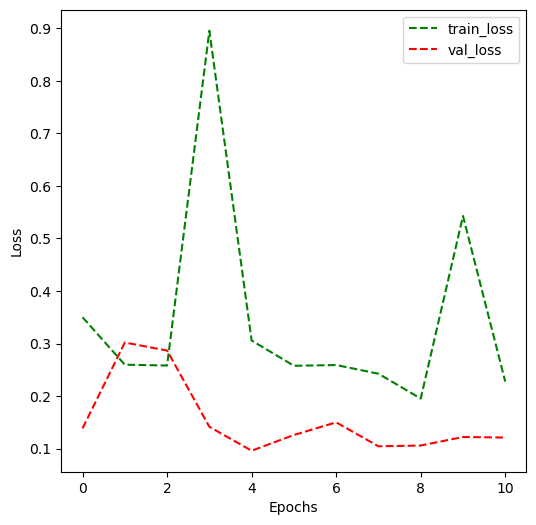

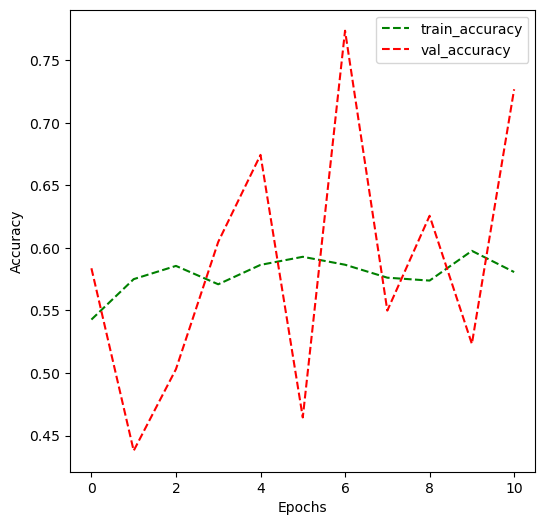

In [8]:
from matplotlib import pyplot

# Plot training loss
pyplot.figure(figsize=(6, 6))

# Plot Training Loss
pyplot.plot(history.history['loss'], label='train_loss', linestyle='--',color='green')
pyplot.plot(history.history['val_loss'], label='val_loss', linestyle='--',color='red')
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.legend()
pyplot.savefig('Training and validation loss.png')
pyplot.show()

# Plot training accuracy
pyplot.figure(figsize=(6, 6))

# Plot Training Accuracy
pyplot.plot(history.history['accuracy'], label='train_accuracy', linestyle='--',color='green')
pyplot.plot(history.history['val_accuracy'], label='val_accuracy', linestyle='--',color='red')
pyplot.xlabel('Epochs')
pyplot.ylabel('Accuracy')
pyplot.legend()
pyplot.savefig('Training and validation accuracy',dpi=500);
pyplot.show()


In [33]:
# Predict on the test set
reconstructed = autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - reconstructed, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                         'true_class': y_test})

705/705 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [13]:
reconstructed

array([[ 0.19797169,  0.26821515,  1.0676953 , ..., -0.5804603 ,
         2.358291  ,  2.235812  ],
       [ 0.19636579,  0.09794703,  0.9262999 , ..., -0.615956  ,
         2.388452  ,  2.2607875 ],
       [ 0.07665917,  0.1806113 , -0.8062623 , ..., -0.7688439 ,
        -0.35771418, -0.43478683],
       ...,
       [-0.0375318 ,  0.12993103, -1.1109234 , ..., -0.58391714,
        -0.13486776, -0.2650258 ],
       [-0.04946287,  2.0204515 , -1.2661167 , ..., -0.5518841 ,
        -0.3310168 , -0.36762947],
       [-0.23878668, -0.7869066 ,  0.92567915, ..., -0.6182672 ,
         1.8031442 ,  1.715555  ]], dtype=float32)

In [17]:
reconstructed.shape

(22544, 40)

In [14]:
mse

array([0.21871059, 0.18118888, 0.02932995, ..., 0.05389713, 0.0226178 ,
       0.19740203], dtype=float32)

In [15]:
mse.shape

(22544,)

In [16]:
error_df

,reconstruction_error,true_class
0,0.218711,1
1,0.181189,1
2,0.029330,0
3,0.229445,1
4,0.088172,1
...,...,...
22539,0.010553,0
22540,0.004476,0
22541,0.053897,1
22542,0.022618,0


In [26]:
percentiles = [70, 75, 80, 85, 90, 95]
thresholds = np.percentile(error_df[error_df['true_class'] == 0]['reconstruction_error'], percentiles)
for perc, thresh in zip(percentiles, thresholds):
    print(f"{perc}th percentile threshold: {thresh}")


70th percentile threshold: 0.017004188150167465
75th percentile threshold: 0.024959150701761246
80th percentile threshold: 0.03514612838625908
85th percentile threshold: 0.062133537605404854
90th percentile threshold: 0.09992153942584991
95th percentile threshold: 0.2031410038471222


In [23]:
error_df[error_df['true_class'] == 0].describe()

,reconstruction_error,true_class
count,9711.000000,9711.0
mean,0.078438,0.0
std,0.668246,0.0
min,0.002706,0.0
25%,0.005297,0.0
50%,0.009228,0.0
75%,0.024959,0.0
max,44.731895,0.0


In [24]:
error_df[error_df['true_class'] == 0].sum()

reconstruction_error    761.713745
true_class                0.000000
dtype: float64

In [21]:
for thresh in thresholds:
    preds = (error_df['reconstruction_error'].values > thresh).astype(int)
    print(f"Threshold: {thresh}")
    print(classification_report(y_test, preds))


Threshold: 0.017004188150167465
              precision    recall  f1-score   support

           0       0.93      0.70      0.80      9711
           1       0.81      0.96      0.88     12833

    accuracy                           0.85     22544
   macro avg       0.87      0.83      0.84     22544
weighted avg       0.86      0.85      0.84     22544

Threshold: 0.024959150701761246
              precision    recall  f1-score   support

           0       0.91      0.75      0.82      9711
           1       0.83      0.95      0.89     12833

    accuracy                           0.86     22544
   macro avg       0.87      0.85      0.85     22544
weighted avg       0.87      0.86      0.86     22544

Threshold: 0.03514612838625908
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      9711
           1       0.86      0.93      0.90     12833

    accuracy                           0.88     22544
   macro avg       0.88      0.87

In [28]:
# Find the threshold based on the validation set
threshold = np.percentile(error_df[error_df['true_class'] == 0]['reconstruction_error'], 80)

# Predict the anomaly (1 for attack, 0 for normal)
y_pred = [1 if e > threshold else 0 for e in error_df['reconstruction_error'].values]

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.80      0.85      9711
           1       0.86      0.93      0.90     12833

    accuracy                           0.88     22544
   macro avg       0.88      0.87      0.87     22544
weighted avg       0.88      0.88      0.88     22544



In [29]:
from sklearn.metrics import matthews_corrcoef
# Calculate MCC
mcc_score = matthews_corrcoef(y_test, y_pred)
print("MCC Score:", mcc_score)

MCC Score: 0.7481036918963894


In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score, roc_curve, auc

outputFile=open('Model Results .txt','a')
confusion= confusion_matrix(y_test, y_pred)

#Overall Accuracy
Accuracy_cla= accuracy_score(y_test, y_pred)
#Precision
Pr_cla=precision_score(y_test, y_pred, average='weighted')
#Sensivity/Recall/TPR
Sn_cla= recall_score(y_test, y_pred, average='weighted')
#F1 Score
F1_cla = f1_score(y_test, y_pred, average='weighted')

#Compute MCC
MCC_cla = matthews_corrcoef(y_test, y_pred)


Results='Independent Test Results:\n'
outputFile.write(str(Results))

print("\nConfusion Matrix")
print("{0}".format(confusion_matrix(y_test, y_pred)))
outputFile.write('Overall Accuracy = %.5f\n'%Accuracy_cla)
outputFile.write('Precision = %.5f\n'%Pr_cla)
outputFile.write('Sensivity/Recall/TPR = %.5f\n'%Sn_cla)
outputFile.write('F1 Score = %.5f\n'%F1_cla)
outputFile.write('MCC = %.5f\n'%MCC_cla)
print("\nClassification Report")
print("{0}".format(classification_report(y_test, y_pred)))

outputFile.close()


Confusion Matrix
[[ 7769  1942]
 [  846 11987]]

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      9711
           1       0.86      0.93      0.90     12833

    accuracy                           0.88     22544
   macro avg       0.88      0.87      0.87     22544
weighted avg       0.88      0.88      0.88     22544



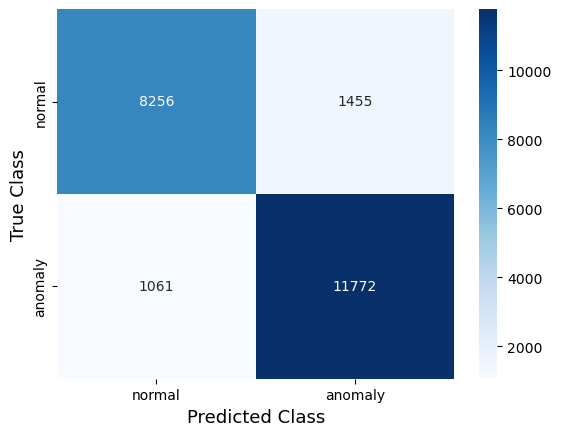

In [292]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion,
            cmap='Blues',
			annot=True,
			fmt='g',
			xticklabels=['normal', 'anomaly'],
			yticklabels=['normal', 'anomaly'])
plt.ylabel('True Class', fontsize=13)
plt.xlabel('Predicted Class', fontsize=13)
plt.savefig('Confusion Matrix for binary Class',dpi=500);
plt.show()

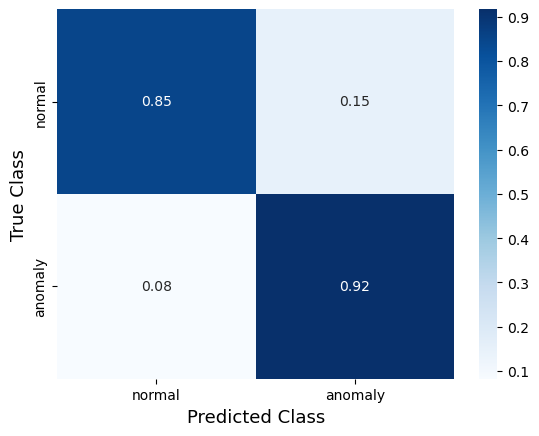

In [293]:
#Normalized confusion matrix
#Divide each row element by the sum of the entire row
cm_normalized = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized,
            cmap='Blues',
			annot=True,
			fmt='.2f',
			xticklabels=['normal', 'anomaly'],
			yticklabels=['normal', 'anomaly'])
plt.ylabel('True Class', fontsize=13)
plt.xlabel('Predicted Class', fontsize=13)
plt.show()

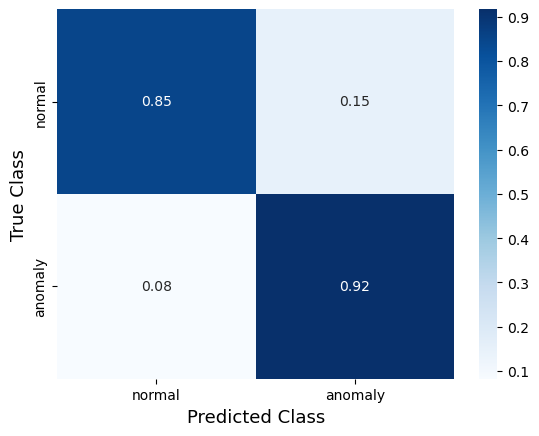

In [294]:
#Normalized confusion matrix
#Divide each row element by the sum of the entire row
cm_normalized = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized,
            cmap='Blues',
			annot=True,
			fmt='.2f',
			xticklabels=['normal', 'anomaly'],
			yticklabels=['normal', 'anomaly'])
plt.ylabel('True Class', fontsize=13)
plt.xlabel('Predicted Class', fontsize=13)
plt.show()

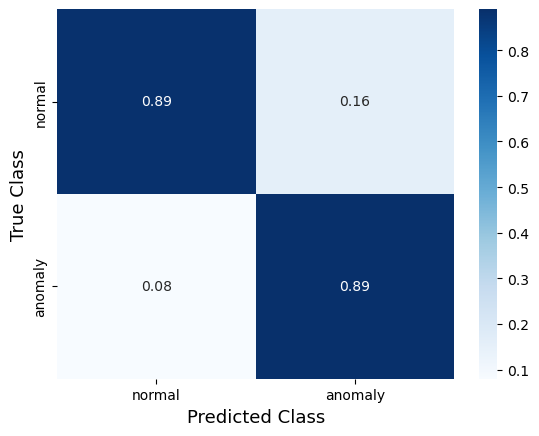

In [296]:
#Normalized confusion matrix
#Divide each column element by the sum of the entire column
cm_normalized = confusion.astype('float') / confusion.sum(axis=0)[:, np.newaxis]

sns.heatmap(cm_normalized,
            cmap='Blues',
			annot=True,
			fmt='.2f',
			xticklabels=['normal', 'anomaly'],
			yticklabels=['normal', 'anomaly'])
plt.ylabel('True Class', fontsize=13)
plt.xlabel('Predicted Class', fontsize=13)
plt.savefig('Normalized Confusion Matrix for binary Class',dpi=500);
plt.show()

705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
AUC for Class 0: 0.94
AUC for Class 1: 0.06


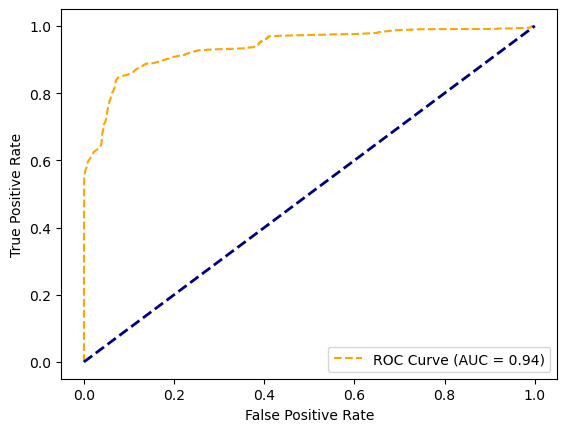

In [334]:
# Prediction and error calculation
reconstructed = autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - reconstructed, 2), axis=1)

# Normalize MSE to convert to pseudo-probabilities
min_error = np.min(mse)
max_error = np.max(mse)
mse_normalized = (mse - min_error) / (max_error - min_error)
pred_prob = 1 - mse_normalized


# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
auc_score = {}
 
n_class = 2

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob, pos_label=i)
    auc_score[i] = auc(fpr[i], tpr[i])


# Print and round AUC scores to 2 decimal places
for i in range(n_class):
    auc_score[i] = round(auc_score[i], 2)
    print("AUC for Class {}: {}".format(i, auc_score[i]))

# plotting
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='ROC Curve (AUC = {})'.format(auc_score[0]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.savefig('ROC Curve for Autoencoder',dpi=500);

705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


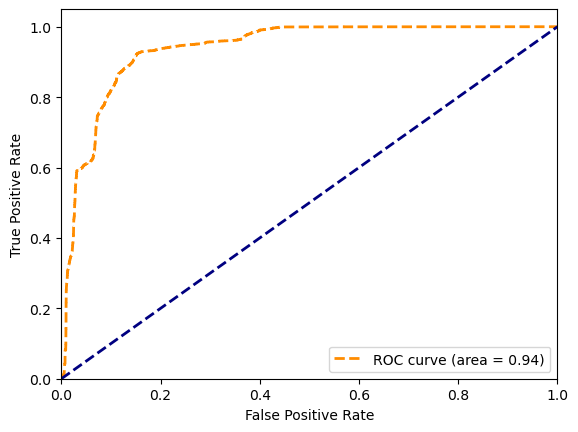

In [335]:
# Prediction and error calculation
reconstructed = autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - reconstructed, 2), axis=1)

# Normalize MSE to convert to pseudo-probabilities
min_error = np.min(mse)
max_error = np.max(mse)
mse_normalized = (mse - min_error) / (max_error - min_error)
pred_prob = mse_normalized

fpr, tpr, thresholds = roc_curve(y_test, pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', linestyle='--',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [336]:
from sklearn.metrics import average_precision_score, precision_recall_curve

# Prediction and error calculation
reconstructed = autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - reconstructed, 2), axis=1)

# Normalize MSE to convert to pseudo-probabilities
min_error = np.min(mse)
max_error = np.max(mse)
mse_normalized = (mse - min_error) / (max_error - min_error)
pred_prob = 1 - mse_normalized

# For each class
n_class = 2
precision = dict()
recall = dict()
thresh = dict()
average_precision = dict()
for i in range(n_class):
    precision[i], recall[i], thresh[i] = precision_recall_curve(y_test, pred_prob, pos_label=i)
    average_precision[i] = average_precision_score(y_test, pred_prob)

# Print and round AUC scores to 2 decimal places
for i in range(n_class):
    average_precision[i] = round(average_precision[i], 2)
    print("Precision-Recall for Class {}: {}".format(i, average_precision[i]))

705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Precision-Recall for Class 0: 0.37
Precision-Recall for Class 1: 0.37


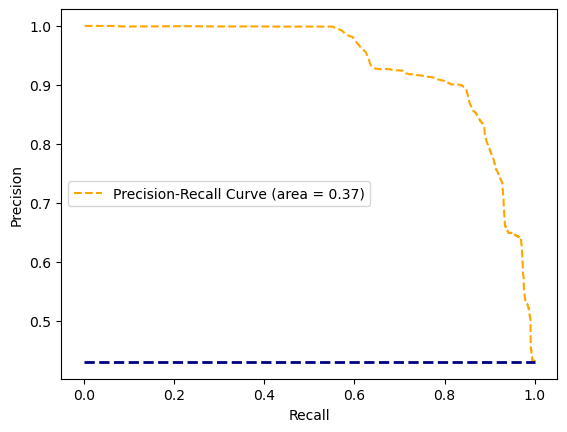

In [337]:
# plotting
plt.plot(recall[0], precision[0], linestyle='--',color='orange', label='Precision-Recall Curve (area = {})'.format(average_precision[0]))
plt.plot([0, 1], [0.43, 0.43], color='navy', lw=lw, linestyle='--')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.savefig('Precision-Recall Curve for Autoencoder',dpi=500);

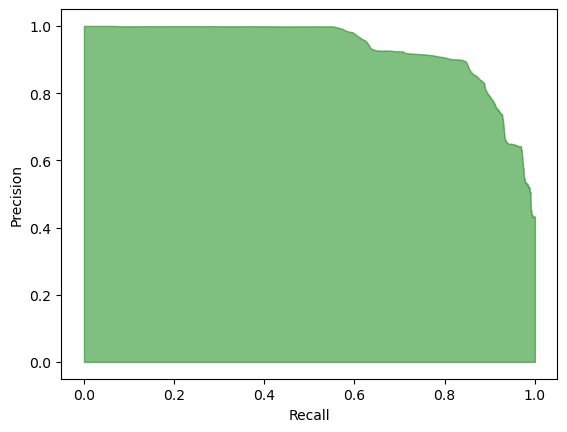

In [343]:
plt.fill_between(recall[0], precision[0], color='green',alpha=0.5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('Precision-Recall Curve for Autoencoder_2',dpi=500);
plt.show()